In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model
from sklearn.model_selection import train_test_split
import sklearn

In [2]:
from biosppy import storage
#from biosppy import eeg
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import math

In [3]:
allStandardRawSignals= []
allFireRawSignals = []
samplingRate = 512

streamWindowSize = 0.51 # streamWindowSize in seconds
    
streamWindowSize = 256   # streamWindowSize converted to 

In [4]:
#formats for the biosppy eeg module text files
def formatRawSignaltoSegments(rawSignal):
    signal=[]
    i= int(round(random.randint(0,streamWindowSize)))
    while(i<(len(rawSignal)-math.ceil(streamWindowSize))):
        streamWindow = []
        for c in range(i, i+ int(math.ceil(streamWindowSize))):
            streamWindow.append(rawSignal[c])
        
        
        signal.append(streamWindow)
        i+= int(math.ceil(streamWindowSize))
        i+= random.randint(0,streamWindowSize)
    return signal    

In [5]:
def formatRawSignaltoSegmentsFire(rawSignal):
    signal=[]
    for c in range(0,5):
        i= int(round(random.randint(0,streamWindowSize)))
        while(i<(len(rawSignal)-math.ceil(streamWindowSize))):
            streamWindow = []
            for c in range(i, i+ int(math.ceil(streamWindowSize))):
                streamWindow.append(rawSignal[c])


            signal.append(streamWindow)
            i+= int(math.ceil(streamWindowSize))
            i+= random.randint(0,streamWindowSize)
    return signal    

In [6]:
#standard
directory = r'C:\\'
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        (signal, mdict) = storage.load_txt(os.path.join(directory, filename))
        signal = formatRawSignaltoSegments(signal)
        for i in range(len(signal)):
            allStandardRawSignals.append(signal[i])    
        
        #print(os.path.join(directory, filename))
    else:
        continue
        


In [7]:
#fire
directory = r'C:\\'
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        (signal, mdict) = storage.load_txt(os.path.join(directory, filename))
        signal = formatRawSignaltoSegmentsFire(signal)
        for i in range(len(signal)):
            allFireRawSignals.append(signal[i])     
        
        #print(os.path.join(directory, filename))
    else:
        continue
        


c:\users\natty\appdata\local\programs\python\python37\lib\site-packages\biosppy\storage.py:436: UserWarning: genfromtxt: Empty input file: "[]"
  data = np.genfromtxt(values, dtype=dtype, delimiter=b'\t')


In [8]:
#print((allStandardRawSignals[len(allStandardRawSignals)-1]))

import pyeeg

bands=[4, 7,12,30,100]

PSI = pyeeg.bin_power((allStandardRawSignals[len(allStandardRawSignals)-2]),bands,samplingRate)

print(PSI)

(array([14303.98525127, 16086.09765011, 19673.51620575, 23752.61343102]), array([0.19377837, 0.21792093, 0.26652026, 0.32178044]))


In [9]:
def scaler(data):
    for i in range(len(data)):
        for c in range(len(data[i])):
            if(data[i][c] > 1000):
                data[i][c] = 1
                
            elif (data[i][c] < -1000):
                data[i][c] = -1
           
            else:
                data[i][c] = data[i][c]/1000
    
    return data
                
        

In [10]:
#put all arrays into one
allXdata = []
allYdata = []
allXval = []
allYval = []
allFFTData = []
allFFTval = []
lengthOfValidation = 2000
allStandardRawSignals = scaler(allStandardRawSignals)
allFireRawSignals = scaler(allFireRawSignals)
for i in range(len(allStandardRawSignals)-lengthOfValidation):
    allYdata.append([1,0])
    allXdata.append(allStandardRawSignals[i])
    allFFTData.append(pyeeg.bin_power(allStandardRawSignals[i], bands, samplingRate)[0]/20000)
for i in range(len(allFireRawSignals)-lengthOfValidation):
    allYdata.append([0,1])
    allXdata.append(allFireRawSignals[i])
    allFFTData.append(pyeeg.bin_power(allFireRawSignals[i], bands, samplingRate)[0]/20000)
    
for i in range(len(allStandardRawSignals)-lengthOfValidation, len(allStandardRawSignals)):
    allYval.append([1,0])
    allXval.append(allStandardRawSignals[i])
    allFFTval.append(pyeeg.bin_power(allStandardRawSignals[i], bands, samplingRate)[0]/20000)
for i in range(len(allFireRawSignals)-lengthOfValidation, len(allFireRawSignals)):
    allYval.append([0,1])
    allXval.append(allFireRawSignals[i])
    allFFTval.append(pyeeg.bin_power(allFireRawSignals[i], bands, samplingRate)[0]/20000)


#print(len(Y_data))
#print(len(X_data))


In [11]:
X_data = np.array(allXdata)
Y_data = np.array(allYdata)
FFT_data = np.array(allFFTData)

X_val = np.array(allXval)
Y_val = np.array(allYval)
FFT_val = np.array(allFFTval)

x_train, y_train, fft_train = sklearn.utils.shuffle(X_data, Y_data, FFT_data)

x_val, y_val, fft_val = sklearn.utils.shuffle(X_val, Y_val, FFT_val)

In [12]:
#x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.25)


x_train = np.reshape(x_train, (x_train.shape[0],streamWindowSize,1))
x_val = np.reshape(x_val, (x_val.shape[0],streamWindowSize,1))
print(fft_val.shape)


(4000, 4)


In [37]:
inputA = layers.Input(shape=( streamWindowSize,1))
inputB = layers.Input(shape=(len(bands)-1,1))

x = layers.Conv1D(40, 10, strides=2, padding='same', activation='relu')(inputA)
#model.add(layers.BatchNormalization())

x = layers.Dropout(0.2)(x)

x= layers.MaxPooling1D()(x)
x = layers.Conv1D(40, 5, strides=2, padding='same', activation='relu')(x)

x =layers.Dropout(0.2)(x)
x = layers.MaxPooling1D()(x)

x = layers.Conv1D(40, 4, strides=1, padding='same', activation='relu')(x)
x = layers.Dropout(0.2)(x)


x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(30, activation='relu')(x)
x = layers.Dropout(0.2)(x)

#y=layers.Conv1D(5,2,activation='relu')(inputB)
#y = layers.Flatten()(inputB)
#y = layers.Dense(15, activation='relu')(y)

x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)

#z = layers.concatenate([x, y])

x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)

#model.add(layers.Dense(32, activation='relu'))
#model.add(layers.Dropout(0.2))

x = layers.Dense(2, activation='softmax')(x)



model = Model(inputs=inputA, outputs=x)


model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 256, 1)]          0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 128, 40)           440       
_________________________________________________________________
dropout_36 (Dropout)         (None, 128, 40)           0         
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 64, 40)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 32, 40)            8040      
_________________________________________________________________
dropout_37 (Dropout)         (None, 32, 40)            0         
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 16, 40)            0   

In [27]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[tf.keras.metrics.FalseNegatives(),tf.keras.metrics.FalsePositives(),'accuracy'])

In [269]:

history = model.fit(x=x_train, y=y_train, batch_size=100, epochs=11, validation_data=(x_val,y_val))


Epoch 1/11
601/601 [==============================] - 9s 14ms/step - loss: 0.5707 - false_negatives_12: 8473.3206 - false_positives_12: 8473.3206 - accuracy: 0.6942 - val_loss: 0.4771 - val_false_negatives_12: 854.0000 - val_false_positives_12: 854.0000 - val_accuracy: 0.7865
Epoch 2/11
601/601 [==============================] - 8s 13ms/step - loss: 0.4833 - false_negatives_12: 6836.8787 - false_positives_12: 6836.8787 - accuracy: 0.7736 - val_loss: 0.4677 - val_false_negatives_12: 834.0000 - val_false_positives_12: 834.0000 - val_accuracy: 0.7915
Epoch 3/11
601/601 [==============================] - 8s 14ms/step - loss: 0.4777 - false_negatives_12: 6683.4468 - false_positives_12: 6683.4468 - accuracy: 0.7784 - val_loss: 0.5006 - val_false_negatives_12: 886.0000 - val_false_positives_12: 886.0000 - val_accuracy: 0.7785
Epoch 4/11
601/601 [==============================] - 8s 14ms/step - loss: 0.4718 - false_negatives_12: 6606.5415 - false_positives_12: 6606.5415 - accuracy: 0.7818 - va

In [270]:
y_pred=model.predict(x_val)
#con_mat = tf.math.confusion_matrix(labels=y_val, predictions=y_pred).numpy()

cf_matrix  = tf.math.confusion_matrix(labels=y_val.argmax(axis=1), predictions=y_pred.argmax(axis=1)).numpy()
print(y_pred.argmax(axis=1))
print(y_val)

[0 0 0 ... 1 0 0]
[[1 0]
 [0 1]
 [1 0]
 ...
 [0 1]
 [1 0]
 [1 0]]


In [271]:

print(cf_matrix)

[[1684  316]
 [ 592 1408]]


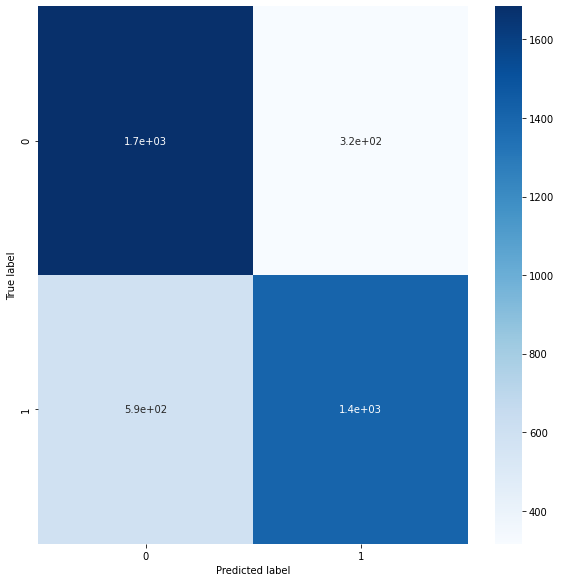

In [272]:
import seaborn as sns


figure = plt.figure(figsize=(8, 8))
sns.heatmap(cf_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label') 
plt.xlabel('Predicted label')
plt.show()

In [273]:
y_test = []
allTestRawSignals = []
fft_test = []
directory = r'C:\\Users\\Natty\Desktop\BrainTests\\PythonBluetoothBrainTest\data\firetest\\'
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        (signal, mdict) = storage.load_txt(os.path.join(directory, filename))
        signal = formatRawSignaltoSegments(signal)
        for i in range(len(signal)):
            allTestRawSignals.append(signal[i]) 
           
            y_test.append(1)   
        #print(os.path.join(directory, filename))
    else:
        continue
#print(fft_test.shape)

allTestRawSignals = scaler(allTestRawSignals)
        

In [274]:

x_test = np.reshape(np.array(allTestRawSignals), (len(allTestRawSignals),streamWindowSize,1))
for i in range(len(x_test)):
    fft_test.append(pyeeg.bin_power(x_test[i], bands, samplingRate)[0]/20000)
    
y_test = np.array(y_test)
fft_test = np.array(fft_test)
#print(x_test)
y_pred=model.predict(x_test)
#con_mat = tf.math.confusion_matrix(labels=y_val, predictions=y_pred).numpy()

cf_matrix  = tf.math.confusion_matrix(labels=y_test, predictions=y_pred.argmax(axis=1)).numpy()
print(y_pred.argmax(axis=1))
#print(y_val)
c=0
for i in y_pred:
    if(i[1] > 0.7):
        c+=1
        print(c)
print(len(y_pred))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 1 1 0 1
 1 1 1 0 0 1 1 1 1 1 1 0 0 0 1 1]
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75


In [275]:
y_test = []
allTestRawSignals = []
fft_test = []
directory = r'C:\\Users\\Natty\Desktop\BrainTests\\PythonBluetoothBrainTest\data\standardtest\\'
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        (signal, mdict) = storage.load_txt(os.path.join(directory, filename))
        signal = formatRawSignaltoSegments(signal)
        for i in range(len(signal)):
            allTestRawSignals.append(signal[i])    
            y_test.append(0)   
        #print(os.path.join(directory, filename))
    else:
        continue
allTestRawSignals = scaler(allTestRawSignals)

In [276]:
x_test = np.reshape(np.array(allTestRawSignals), (len(allTestRawSignals),streamWindowSize,1))
for i in range(len(x_test)):
    fft_test.append(pyeeg.bin_power(x_test[i], bands, samplingRate)[0]/1000)
y_test = np.array(y_test)
fft_test = np.array(fft_test)
#print(x_test)
y_pred=model.predict(x_test)
#con_mat = tf.math.confusion_matrix(labels=y_val, predictions=y_pred).numpy()

cf_matrix  = tf.math.confusion_matrix(labels=y_test, predictions=y_pred.argmax(axis=1)).numpy()
c=0
for i in y_pred:
    if(i[1] > 0.7):
        c+=1 
        print(c)
print(cf_matrix)
#print(y_val)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [277]:
from pathlib import Path
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model=converter.convert()
print(Path('model13.tflite').write_bytes(tflite_model))
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Natty\AppData\Local\Temp\tmpr2jffowz\assets


INFO:tensorflow:Assets written to: C:\Users\Natty\AppData\Local\Temp\tmpr2jffowz\assets


88236
